In [22]:
from PIL import Image
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from keras.applications import VGG16
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.models import Model, Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm

In [2]:
# Chemins des dossiers
data_directory = r'C:\Users\skrfa\Desktop/Réseaux_de_neurones/malaria_hematie_dataset'
saines_directory = r'C:\Users\skrfa\Desktop/Réseaux_de_neurones/malaria_hematie_dataset/saines'
infectees_directory = r'C:\Users\skrfa\Desktop/Réseaux_de_neurones/malaria_hematie_dataset/infectees'

In [3]:
# Préprocesser les images
def preprocess_images(folder_path, label, target_size=(128, 128)):
    images = []
    labels = []
    for filename in tqdm(os.listdir(folder_path)):
        img_path = os.path.join(folder_path, filename)
        if os.path.isfile(img_path):
            img = load_img(img_path, target_size=target_size)
            img_array = img_to_array(img)
            images.append(img_array)
            labels.append(label)
    return np.array(images), labels

In [4]:
# préprocesser les images infectees
infectees_images, infectees_labels = preprocess_images(r'C:\Users\skrfa\Desktop/Réseaux_de_neurones/malaria_hematie_dataset/infectees', 'infectees')

# préprocesserles images saines
saines_images, saines_labels = preprocess_images(r'C:\Users\skrfa\Desktop/Réseaux_de_neurones/malaria_hematie_dataset/saines', 'saines')

100%|███████████████████████████████████████████████████████████████████████████| 13779/13779 [00:44<00:00, 307.35it/s]


***Assurer que toutes les images ont la même shape permet de garantir que les données sont prêtes pour l'entraînement***

In [5]:
# shape des images
print("Image infectees Shapes:", set(img.shape for img in infectees_images))
print("Image Saines Shapes:", set(img.shape for img in saines_images))

Image infectees Shapes: {(128, 128, 3)}
Image Saines Shapes: {(128, 128, 3)}


In [6]:
# Concatenater les données Preprocesser
images = np.concatenate((infectees_images, saines_images))
labels = infectees_labels + saines_labels

In [7]:
# Normalisation des images
images_normalized = images / 255.0

In [8]:
# Encodage des labels
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

**Vérifier les shapes et le nombre des labels est necessaire pour verifier la cohérence des données et detecter les erreurs** 

In [9]:
# Vérifier les shapes et le nombre des labels  
print("Shape of Images:", images.shape)
print("Length of Labels:", len(labels_encoded))

Shape of Images: (27558, 128, 128, 3)
Length of Labels: 27558


**Data augmentation :** est une technique utilisée pour augmenter la diversité de l'ensemble de données d'entraînement sans collecter de nouvelles données et pour reduire le surapprentissage

In [10]:
# Augmentation des données
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

**Definir les dimensions des images et créer un modèle CNN en utilisant Keras pour la classification des images d'hématies infectées et saines**

In [25]:
# Détermination des dimensions des images prétraitées ==> Récupère les dimensions des images prétraitées (hauteur, largeur)
img_height, img_width, channels = images.shape[1:]

# Détermination du nombre de classes uniques ==> Détermine le nombre de classes uniques dans les labels encodés
num_classes = len(np.unique(labels_encoded))

# Construction du modèle CNN 
model = Sequential([
    # Première couche de convolution et pooling
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, channels)),
    MaxPooling2D((2, 2)),
    
    # Deuxième couche de convolution et pooling
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    
    # Flattening
    Flatten(),
    
    # Couche dense avec dropout
    Dense(128, activation='relu'),
    Dropout(0.5),
    
    # Couche de sortie
    Dense(num_classes, activation='softmax')
])

C:\Users\skrfa\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [12]:
# Chargement du modèle VGG16
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))

# Récuperation de l'encodeur pré-entraîné
for layer in base_model.layers:
    layer.trainable = False

# Construction du modèle et ajouter des couches Dense
x = Flatten()(base_model.output)  # Flatten pour connecter à des couches Dense
x = Dense(128, activation='relu')(x)  # Couche Dense avec 128 neurones et activation ReLU
x = Dropout(0.5)(x)  # Dropout de 50% pour la régularisation
predictions = Dense(num_classes, activation='softmax')(x)  # Couche de sortie avec activation softmax

# Création du modèle final avec l'encodeur pré-entraîné et les nouvelles couches
model_vgg = Model(inputs=base_model.input, outputs=predictions)

In [13]:
# Définition des callbacks
callbacks = [
    EarlyStopping(patience=3, monitor='val_loss'),
    ReduceLROnPlateau(factor=0.1, patience=2, monitor='val_loss')
]

# Compilation et entraînement des modèles
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(images_normalized, labels_encoded, epochs=10, validation_split=0.2, callbacks=callbacks)

Epoch 1/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 211s 298ms/step - accuracy: 0.6684 - loss: 0.6568 - val_accuracy: 0.9060 - val_loss: 0.3105 - learning_rate: 0.0010
Epoch 2/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 194s 281ms/step - accuracy: 0.9220 - loss: 0.2293 - val_accuracy: 0.9474 - val_loss: 0.2192 - learning_rate: 0.0010
Epoch 3/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 208s 302ms/step - accuracy: 0.9411 - loss: 0.1735 - val_accuracy: 0.8922 - val_loss: 0.3031 - learning_rate: 0.0010
Epoch 4/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 204s 295ms/step - accuracy: 0.9514 - loss: 0.1392 - val_accuracy: 0.8687 - val_loss: 0.2913 - learning_rate: 0.0010
Epoch 5/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 204s 295ms/step - accuracy: 0.9612 - loss: 0.1069 - val_accuracy: 0.9144 - val_loss: 0.2283 - learning_rate: 1.0000e-04


In [17]:
# Sauvegarde des poids des modèles
model.save_weights('model_weights.weights.h5')

**Calculer la Matrice de Confusion**

*Le calcul de la matrice de confusion permet d'obtenir une vue complète et détaillée des performances du modèle de classification, d'identifier les types d'erreurs que le modèle fait, et de calculer des métriques de performance*

In [18]:
# Séparation en ensembles d'entraînement et de test
# On utilise 80% des données pour l'entraînement et 20% pour le test
X_train, X_test, y_train, y_test = train_test_split(images_normalized, labels_encoded, test_size=0.2, random_state=42)

# Faire des prédictions sur le jeu de test
# Les prédictions sont les probabilités des classes
y_pred_prob = model.predict(X_test)

# Convertir les probabilités en classes prédites
y_pred = np.argmax(y_pred_prob, axis=1)

# Calculer la matrice de confusion
# Compare les classes réelles (y_test) aux classes prédites (y_pred)
cm = confusion_matrix(y_test, y_pred)

# Afficher la matrice de confusion
print("Matrice de Confusion :\n", cm)

173/173 ━━━━━━━━━━━━━━━━━━━━ 11s 65ms/step
Matrice de Confusion :
 [[2750   47]
 [ 173 2542]]


**Calculer les métriques de performance**

In [20]:
# Calculer les différentes métriques
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Afficher les métriques
print("Accuracy :", accuracy)
print("Precision :", precision)
print("Recall :", recall)
print("F1-Score :", f1)

# Afficher le rapport de classification
print("Rapport de Classification :\n", classification_report(y_test, y_pred))

Accuracy : 0.9600870827285921
Precision : 0.9818462726921592
Recall : 0.936279926335175
F1-Score : 0.9585218702865762
Rapport de Classification :
               precision    recall  f1-score   support

           0       0.94      0.98      0.96      2797
           1       0.98      0.94      0.96      2715

    accuracy                           0.96      5512
   macro avg       0.96      0.96      0.96      5512
weighted avg       0.96      0.96      0.96      5512



**Graphique ROC et calcule l’AUC de chacun des 3 modèles :**
*La courbe ROC est un graphique qui illustre les performances d'un modèle de classification binaire en montrant la relation entre le taux de vrais positifs (TPR ou sensibilité) et le taux de faux positifs (FPR) pour différents seuils de décision.*

173/173 ━━━━━━━━━━━━━━━━━━━━ 11s 65ms/step


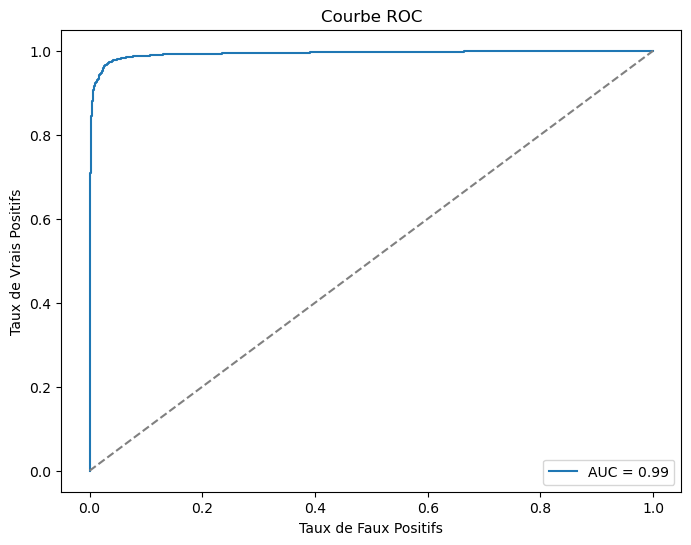

AUC : 0.992696726497938


In [24]:
# Obtenir les probabilités prédites pour chaque classe 
y_prob = model.predict(X_test)

# Si y_prob a plusieurs colonnes (classes), on prend la deuxième colonne (index 1)
if y_prob.shape[1] > 1:
    y_prob = y_prob[:, 1] 
else:
    y_prob = y_prob.ravel()  

# Calculer les taux de faux positifs (FPR) et de vrais positifs (TPR) pour différentes valeurs de seuil afin de tracer la courbe ROC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# Calculer l'AUC (Area Under the Curve)
auc = roc_auc_score(y_test, y_prob)

# Afficher la courbe ROC
plt.figure(figsize=(8, 6))  
plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')  
plt.plot([0, 1], [0, 1], linestyle='--', color='grey')  
plt.xlabel('Taux de Faux Positifs')  
plt.ylabel('Taux de Vrais Positifs')  
plt.title('Courbe ROC')  
plt.legend()  
plt.show()  

print("AUC :", auc)

**Conclusion :**
*Avec un AUC de 0.992696726497938, vous pouvez conclure que votre modèle est exceptionnellement bon pour distinguer entre les hématies saines et infectées, ce qui le rend très utile pour le diagnostic automatique de maladies comme le paludisme*